In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

from tools.misc_tools import get_h5_data
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# **Windowing Technique:**

In [156]:

from tools.misc_tools import get_fpath_sim
from tools.plotter import plot_from_array
from tools.solvers.kolmogorov import TimeStepper3D
import copy 

material_params = {'W': 20, 'beta': 0.9, 'Re': 0.5, 'L':np.inf, 'eps': 1e-3}
system_params = {'Lx': 3*np.pi,  'Lz': 2*np.pi, 'ndim': 3, 'n':1}
solver_params = {'Nx': 64, 'Ny': 64, 'Nz': 32}

system_params_temp = copy.deepcopy(system_params)
system_params_temp['ndim'] = 2
timestepper = TimeStepper3D(material_params=material_params, solver_params=solver_params, system_params=system_params_temp)
base_flow = timestepper.base_flow_full

data_fields, _ = get_h5_data(material_params, system_params, solver_params, suffix='recent-periodic', subdir='arrowhead_3D', s=-1)

x, y, z = data_fields['x'], data_fields['y'], data_fields['z']

fields = ['p', 'c11', 'c12', 'c22', 'u', 'v']

p = data_fields['p'][-1,:,:,:] - base_flow['p'][[0], None, :]
c11 = data_fields['c11'][-1,:,:,:] - base_flow['c11'][[0], None, :]
c12 = data_fields['c12'][-1,:,:,:] - base_flow['c12'][[0], None, :]
c22 = data_fields['c22'][-1,:,:,:] - base_flow['c22'][[0], None, :]

trace = c11 + c22 

# for field_name in fields:
#     base_field = base_flow[field_name]
#     field_array = data_fields[field_name][-1,:,:,:] - base_field[None, :, None]
#     field_int = np.max(np.abs(field_array), axis=(0,2))
#     field_int /= np.max(field_int)

#     plt.plot(z, field_int)

# print(np.max(np.abs(data_fields['u'][-1,:,:,:] - base_flow['u'][None, :, None]), axis=(0,2)))

# plt.legend(fields)

# plt.xlabel('z')
# plt.ylabel(r'$max_{x,y}(f)/max_{x,y,z}(f)$')

2025-02-18 15:50:58,693 cfd_tools.cartesian_systems.cartesian_system_base 0/1 INFO :: Baseflow converged!...


IndexError: list index out of range

In [61]:
Lx = system_params['Lx']

In [38]:
from cfd_tools.cartesian_systems.misc_tools import shift_reflect

mean_c22_y = np.mean(c22, axis=(0,1))

Ny = mean_c22_y.shape[0]
if mean_c22_y[0] > mean_c22_y[Ny//2]:
    # u = shift_reflect(u, parity='odd')
    # v = shift_reflect(v, parity='even')
    p = shift_reflect(p, parity='even')
    trace = shift_reflect(trace, parity='even')
    c22 = shift_reflect(c22, parity='even')

In [39]:
def draw_surface(array1, x, y, z, ax=None, level_mult=0.7, color='tab:blue'):

    level_val = (np.max(array1) - np.min(array1)) * level_mult + np.min(array1)

    try:
        verts, faces, _, _ = marching_cubes(array1, level=level_val, step_size=2, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        
        verts[:, 0] += x[0]
        verts[:, 1] += y[0]
        verts[:, 2] += z[0]

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        ls = LightSource(azdeg=245.0, altdeg=245.0)
        mesh = Poly3DCollection(verts[faces], shade=True, lightsource=ls, facecolors=color, edgecolors='k')

        ax.add_collection3d(mesh)
    except:
        pass

In [153]:

def plot_3D_surface(array1, x, y, z, ax=None, level_mult=0.7):
    if not np.all(np.isclose(np.diff(x, n=2), 0)) or not np.all(np.isclose(np.diff(y, n=2), 0)) or not np.all(np.isclose(np.diff(z, n=2), 0)):
        raise Exception("Grids not equally spaced. Marching Cube Algorithm will be weird...")
    x, y, z = x, z, y

    if ax is None:
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')

    ax.set_box_aspect((np.max(x)-np.min(x), np.max(y)-np.min(y), np.max(z)-np.min(z)), zoom=0.9)

    if isinstance(level_mult, float): 
        draw_surface(array1, x, y, z, ax, level_mult, 'tab:blue')
    elif isinstance(level_mult, list):
        draw_surface(array1, x, y, z, ax, level_mult[0], 'tab:blue')
        draw_surface(array1, x, y, z, ax, level_mult[1], 'tab:red')

    ax.set_xlabel("x", labelpad=20, fontsize=32)
    ax.set_ylabel("z", labelpad=40, fontsize=32)
    ax.set_zlabel("y",labelpad=10, fontsize=32)
    
    ax.set_xlim(np.min(x), np.max(x))  
    ax.set_ylim(np.min(y), np.max(y)) 
    ax.set_zlim(np.min(z), np.max(z))  

    ax.view_init(elev=30, azim=25, roll=0)

    ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=20)
    ax.set_zticks([-np.pi, 0, np.pi, ], [r'$-\pi$', '0', r'$\pi$'], fontsize=20)
    ax.set_yticks([0, 1*np.pi, 2*np.pi, 3*np.pi, -1*np.pi, -2*np.pi, -3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$-\pi$', r'$-2\pi$', r'$-3\pi$'], fontsize=20)
    plt.tight_layout()

    return ax

/tmp/ipykernel_21620/1447345479.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


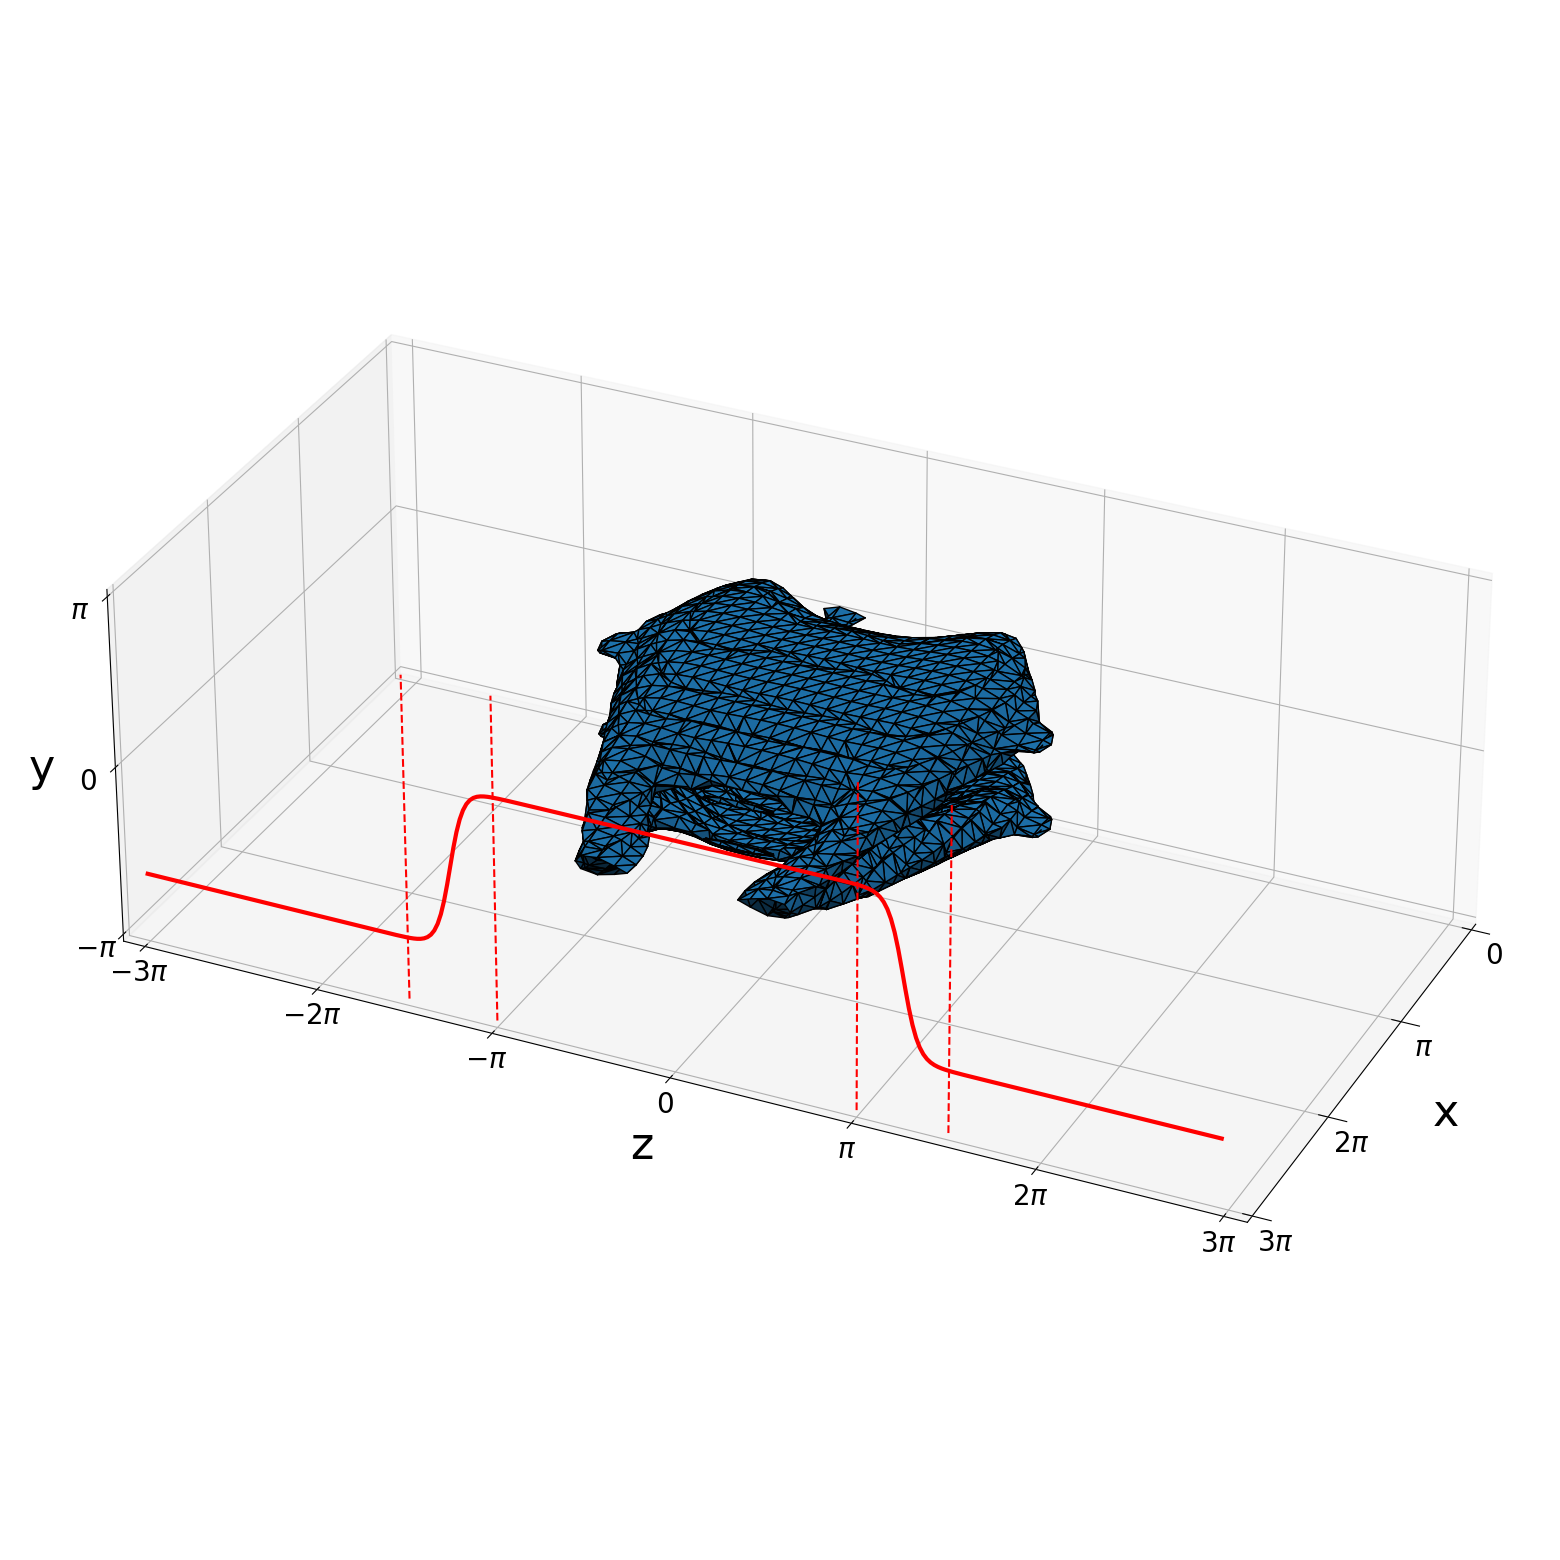

In [ ]:
a, b = np.pi, np.pi/2
plt.rcParams['font.size'] = 40


ax = plot_3D_surface(trace, x, y, z, ax=None, level_mult=0.5)

z_plot = np.linspace(np.min(z), np.max(z), 300)
window = 1/4 * (1 + np.tanh(6 * (a - z_plot) / b + 3)) * (1 + np.tanh(6 * (a + z_plot) / b + 3))

ax.plot(z_plot, (window*3-2), zs=Lx, zdir='x', color='red', zorder=10, linewidth=3)
ax.plot([-a, -a], [-np.pi, np.pi-0.3], zs=Lx, zdir='x', color='red', linestyle='--', zorder=10)
ax.plot([a, a], [-np.pi, np.pi-0.3], zs=Lx, zdir='x', color='red', linestyle='--', zorder=10)
ax.plot([-a-b, -a-b], [-np.pi, np.pi-0.3], zs=Lx, zdir='x', color='red', linestyle='--', zorder=10)
ax.plot([a+b, a+b], [-np.pi, np.pi-0.3], zs=Lx, zdir='x', color='red', linestyle='--', zorder=10)
# ax.scatter3D([Lx, Lx], [-a, a], [-2, -2], color='red', zorder=20)
